In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install seqeval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=eeeed43cbf8eb82afc18a782f6bb8de54b19ed978154aa14c37d4681d3cdf2d0
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
import sys
import json
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from torch.nn.utils import clip_grad_norm
import numpy as np
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from seqeval.metrics import accuracy_score
from seqeval.metrics import classification_report
from seqeval.metrics import f1_score
from seqeval.metrics import accuracy_score
from seqeval.scheme import IOB2
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
import seaborn as sns
import matplotlib.pyplot as plt

path = '/content/drive/MyDrive/magistrale/nlp/nlp2023-hw1-main/data/'
path1 = '/content/drive/MyDrive/magistrale/nlp/nlp2023-hw1-main/hw1/'
sys.path.append(path)

In [4]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip
!ls -lat

--2023-05-01 19:28:57--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-05-01 19:28:57--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-05-01 19:28:57--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [3]:
import os
import torch

class Dictionary(object):
    def __init__(self):

        # Get the current directory
        current_dir = os.getcwd()

        # Get the path to the model weights file
        glove_embeddings_path = os.path.join("model", "glove.6B.50d.txt")
        
        # Define label-to-index mapping
        self.label2idx = {
         'O': 0,
         'B-ACTION':1,
         'B-CHANGE':2,
         'B-SCENARIO':3,
         'B-POSSESSION':4,
         'B-SENTIMENT':5,
         'I-SCENARIO':6,
         'I-ACTION':7,
         'I-CHANGE':8,
         'I-SENTIMENT':9,
         'I-POSSESSION':10
          }

        # Load glove embeddings
        self.glove_tokens,self.glove_embeddings = self.process_glove_embeddings(glove_embeddings_path)
        
        # Build word-to-index and index-to-label mappings
        self.word2idx = {word: index for index, word in enumerate(self.glove_tokens)}
        self.idx2label = {v: k for k, v in self.label2idx.items()}

    def process_glove_embeddings(self, path):
        """
        This function processes the glove embeddings by loading them from a file and adding <unk> and <pad> tokens.
        """
        glove_tokens = []
        glove_embeddings = []

        with open(path, 'rt') as f:
            full_content = f.read().strip().split('\n')
            for i in range(len(full_content)):
                i_word = full_content[i].split(' ')[0]
                i_embeddings = [float(val) for val in full_content[i].split(' ')[1:]]
                glove_tokens.append(i_word)
                glove_embeddings.append(i_embeddings)

        glove_embeddings = torch.tensor(glove_embeddings)

        # Add <unk> token embedding as the mean of all other embeddings
        glove_tokens.append("<unk>")
        unk_emb = torch.mean(glove_embeddings, dim=0, keepdim=True)
        glove_embeddings = torch.cat((glove_embeddings,unk_emb))

        # Add <pad> token embedding as zeros
        glove_tokens.append("<pad>")
        pad_emb = torch.zeros((1, glove_embeddings.shape[1]))
        glove_embeddings = torch.cat((glove_embeddings,pad_emb))

        return (glove_tokens,glove_embeddings)

    def get_embed_glove(self):
        """
        This function returns the glove embeddings
        """
        return self.glove_embeddings

    def __len__(self):
        """
        This function returns the length of the word-to-index mapping
        """
        return len(self.word2idx)


In [4]:
class TextProcessTrain(object):
    # We indicate 1 as the unknown word
    # And we indicate 0 as the padding

    def __init__(self,dictionary):
        self.dictionary = dictionary 
        self.x = []
        self.y = []
        self.max_length_word = 0
        self.len = 0
        # data loading


    def get_data_train(self, datapath):
        with open(path + datapath, 'r') as f:
          for line in f:
            data = json.loads(line)
            self.x.append([ word.lower() for word in data['tokens'] ] )
            self.y.append(data['labels'])

 
        #for tokens in self.x:
          #for token in tokens:
          #  self.dictionary.add_word_training(token)
              
        self.max_length_word = max(len(t[0]) for t in self.x)
        self.n_tokens = len(self.dictionary)

    def get_data_test(self, datapath, max_length_word):
      # here the vocabulary is already defined

        with open(os.path.join("model",datapath), 'r') as f:
          for line in f:
            data = json.loads(line)
            self.x.append(data['tokens'])
            self.y.append(data['labels'])
        self.max_length_word = max_length_word


    def __getitem__(self, index):
      # so if the word doesn't exists ill return 1
      #word = torch.LongTensor([ self.dictionary.word2idx.get(word, 1) or 1 for word in self.x[index] ])
      #word_idxs = []
      #for word in self.x[index]:
      #  if dictionary.get_word_training(word):
       #   word_idxs.append( self.dictionary.word2idx.get(word, self.dictionary.word2idx["<unk>"]) )
       # else:
       #    word_idxs.append(self.dictionary.word2idx["<unk>"])

      word = torch.LongTensor([ self.dictionary.word2idx.get(word, self.dictionary.word2idx["<unk>"]) for word in self.x[index] ])
     # word = torch.LongTensor(word_idxs)
      #word = torch.LongTensor(word_idxs)
      label = torch.LongTensor([ self.dictionary.label2idx[label] for label in self.y[index] ])


      # add padding to all the words and label so that they all are the same length
      word = torch.nn.functional.pad(word, (0, self.max_length_word - len(word)), "constant",self.dictionary.word2idx["<pad>"]  )
      label = torch.nn.functional.pad(label, (0, self.max_length_word - len(label)), "constant",self.dictionary.word2idx["<pad>"]  )
      #print(word)
      return  word,label

        #return self.x[index], self.y[index]

    def is_element_in_nested_list(list, element):
        for sublist in list:
            if element in sublist:
                return True


    def __len__(self):
        return len(self.x)
        

In [ ]:
ks = [[1,2,3],[4,5,6]]
print([1,2,3] in ks)

True


In [5]:
class TextGenerator(nn.Module):
    
    def __init__(self, output_layer_size, vocab_size, hidden_size, num_layers, batch_size,dictionary):
        super(TextGenerator, self).__init__()
        self.num_embeddings, self.embedding_dim = dictionary.get_embed_glove().size()

        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.output_layer_size = output_layer_size
        self.num_layers = num_layers
        #self.hidden = self.init_hidden()
        
        self.embed = torch.nn.Embedding.from_pretrained(dictionary.get_embed_glove(), padding_idx=dictionary.word2idx["<pad>"], freeze=False) 
        #self.lstm = nn.LSTM( self.embedding_dim, hidden_size, num_layers, batch_first=True,bidirectional =True)
        self.lstm = nn.GRU( self.embedding_dim, hidden_size, num_layers, batch_first=True,bidirectional =True)
        #self.linear_01 = nn.Linear(hidden_size*2, output_layer_size)
        self.linear_01 = nn.Linear(hidden_size*2, output_layer_size)
        #self.linear_02 = nn.Linear(1024, output_layer_size)
        #self.linear_03 = nn.Linear(1024, 1024)
        #self.linear_03 = nn.Linear(1024, 512)
        #self.linear_04 = nn.Linear(1024, output_layer_size)


    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return (torch.zeros(2*self.num_layers, self.batch_size, self.hidden_size),
                torch.zeros(2*self.num_layers, self.batch_size, self.hidden_size))
        
    def forward(self, x, epoch=0, optimizer=0):
        #we change the learning rate and the embed. will start to train:https://stackoverflow.com/questions/58630101/using-torch-nn-embedding-for-glove-should-we-fine-tune-the-embeddings-or-just-u
        if epoch==1 and self.embed.weight.requires_grad == False:
          self.embed.weight.requires_grad = True
          for param_group in optimizer.param_groups:
             param_group['lr'] = 0.12
        # Perform Word Embedding 
        #h,c = self.hidden
        #torch.nn.init.xavier_normal_(h)
        #torch.nn.init.xavier_normal_(c)
      
        embeds = self.embed(x)
        #print(embeds.shape)
        #Reshape the input tensor
        #x = x.view(batch_size,timesteps,embed_size)
        #print(self.hidden[0].shape)
        #packed_embeds = pack_padded_sequence(a, [6], batch_first=True, enforce_sorted=False)
        out, _ = self.lstm(embeds)
        # Flatten output tensor for use in the linear layer
        #print(out.shape)
        #out = self.dropout(out)
        out = self.linear_01(out)
        #out = torch.nn.functional.relu(self.linear_02(out))
        #out = self.dropout(out)
        #out = self.linear_02(out)
        #out = self.linear_01(out[:, -1])
        #out = self.dropout(out)
        #out = torch.nn.functional.relu(self.linear_03(out))
        #out = self.dropout(out)
        #out = self.linear_03(out)
        #out = self.linear_04(out)
        return out

In [6]:
hidden_size = 512  #Number of LSTM units
num_layers = 1 
num_epochs = 50 
batch_size = 32
learning_rate = 0.2


In [7]:

dictionary = Dictionary()
corpusTrain = TextProcessTrain(dictionary)
corpusTrain.get_data_train("train.jsonl")

corpusTest = TextProcessTrain(dictionary)
corpusTest.get_data_test("test.jsonl",corpusTrain.max_length_word)


corpusVal = TextProcessTrain(dictionary)
corpusVal.get_data_test("dev.jsonl",corpusTrain.max_length_word)

In [8]:

train_loader = DataLoader(dataset=corpusTrain, batch_size=batch_size,shuffle=False,pin_memory=True)
test_loader = DataLoader(dataset=corpusTest, batch_size=batch_size,shuffle=False,pin_memory=True,drop_last=True,num_workers=0)
validation_loader = DataLoader(dataset=corpusVal, batch_size=batch_size,shuffle=False,pin_memory=True,drop_last=True,num_workers=0)

# Display image and label.
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")


for step, sample in tqdm(enumerate( validation_loader ),desc="Batch"):
    print(sample[0].shape)
    break

Feature batch shape: torch.Size([32, 20])
Labels batch shape: torch.Size([32, 20])


Batch: 0it [00:00, ?it/s]

torch.Size([32, 20])


In [9]:
vocab_size = len(corpusTrain.dictionary)
output_layer_size = len(dictionary.label2idx)
print(vocab_size)
print(output_layer_size)

400002
11


In [10]:
model = TextGenerator(output_layer_size, vocab_size, hidden_size, num_layers,batch_size,dictionary)
print(model)

TextGenerator(
  (embed): Embedding(400002, 50, padding_idx=400001)
  (lstm): GRU(50, 512, batch_first=True, bidirectional=True)
  (linear_01): Linear(in_features=1024, out_features=11, bias=True)
)


In [11]:
loss_fn = nn.CrossEntropyLoss(ignore_index=dictionary.word2idx["<pad>"])
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
print(dictionary.word2idx["<pad>"])



model.load_state_dict(torch.load(os.path.join("model", "model_weights.pth")))
model.eval()

400001


TextGenerator(
  (embed): Embedding(400002, 50, padding_idx=400001)
  (lstm): GRU(50, 512, batch_first=True, bidirectional=True)
  (linear_01): Linear(in_features=1024, out_features=11, bias=True)
)

In [ ]:
train_loss = 0.0

for epoch in range(num_epochs):


    epoch_loss = 0.0
    len_train = 0
    target_tokens = []
    output_tokens = []

    with tqdm(enumerate( train_loader ),desc="Batch", leave=False) as data:
      
      for step, sample in data:

          model.zero_grad()
          inputs = sample[0]
          targets = sample[1] 
          model.hidden = model.init_hidden()
          # Also, we need to clear out the hidden state of the LSTM, detaching it from its
          # history on the last instance.           targets.reshape(-1)
          

          outputs = model(inputs,step,optimizer)

          #print(targets[:,:11].shape)
          loss = loss_fn(outputs.view(-1, outputs.shape[-1]), targets.view(-1))

         
          loss.backward()
          #Perform Gradient Clipping. clip_value (float or int) is the maximum allowed value of the gradients 
          #The gradients are clipped in the range [-clip_value, clip_value]. This is to prevent the exploding gradient problem
          clip_grad_norm(model.parameters(), 0.5)
          optimizer.step()
          epoch_loss += loss.item()
          len_train += 1
    
          avg_epoch_loss = epoch_loss / len_train     
          if step % 10 == 0:
            print('Epoch: {} avg loss = {:0.4f} loss = {:0.4f} '.format(epoch, avg_epoch_loss,loss.item()))

          train_loss += avg_epoch_loss
    # At the end of the epoch we evaluate the model for tuning
    with torch.no_grad():
     with tqdm(enumerate( validation_loader ),desc="Batch", leave=False) as data:
      for step, sample in data:
            inputs = sample[0]
            targets = sample[1]

            #print(targets)
            output = model(inputs)
            #print(torch.argmax(output,-1))
            #fscore = F_score(torch.argmax(output,-1), targets)

            #convert from id to tokens 
            #delete the paddings to evaluate
            for true,pred in zip(targets,torch.argmax(output,-1)):

              if dictionary.word2idx["<pad>"] in true:
                start_index = true.tolist().index(dictionary.word2idx["<pad>"])
    
                true = true[:start_index]
                true = [dictionary.idx2label[idx.item()] for idx in true]

                target_tokens.append(true)

                pred = pred[:start_index]
                pred = [dictionary.idx2label[idx.item()] for idx in pred]
                output_tokens.append(pred)
              else:
                true = [dictionary.idx2label[idx.item()] for idx in true]
                target_tokens.append(true)
                pred = [dictionary.idx2label[idx.item()] for idx in pred]
                output_tokens.append(pred)
    print("f1 score:"+str(f1_score(target_tokens, output_tokens, mode="strict", scheme=IOB2,zero_division=False)))                


avg_epoch_loss = train_loss / num_epochs

print("avarage epoch loss = " + str(avg_epoch_loss))

Batch: 0it [00:00, ?it/s]

<ipython-input-14-676bdd3a2bcc>:32: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  clip_grad_norm(model.parameters(), 0.5)


Epoch: 0 avg loss = 0.0967 loss = 0.0967 
Epoch: 0 avg loss = 0.1064 loss = 0.1219 
Epoch: 0 avg loss = 0.1070 loss = 0.0939 
Epoch: 0 avg loss = 0.1081 loss = 0.1374 
Epoch: 0 avg loss = 0.1072 loss = 0.1170 


In [12]:


torch.set_printoptions(sci_mode=False,threshold=sys.maxsize)



target_tokens = []
output_tokens = []
# Test the model
with torch.no_grad():
    with tqdm(enumerate( test_loader ),desc="Batch", leave=False) as data:
      for step, sample in data:
            inputs = sample[0]
            targets = sample[1]

            #print(targets)
            output = model(inputs)
            #print(torch.argmax(output,-1))

            #convert from id to tokens 
            #delete the paddings to evaluate
            for true,pred in zip(targets,torch.argmax(output,-1)):

              if dictionary.word2idx["<pad>"] in true:
                start_index = true.tolist().index(dictionary.word2idx["<pad>"])
    
                true = true[:start_index]
                true = [dictionary.idx2label[idx.item()] for idx in true]

                target_tokens.append(true)

                pred = pred[:start_index]
                pred = [dictionary.idx2label[idx.item()] for idx in pred]
                output_tokens.append(pred)
              else:
                true = [dictionary.idx2label[idx.item()] for idx in true]
                target_tokens.append(true)
                pred = [dictionary.idx2label[idx.item()] for idx in pred]
                output_tokens.append(pred)




Batch: 0it [00:00, ?it/s]

In [13]:
print("classification score:\n"+str(classification_report(target_tokens, output_tokens, mode="strict", scheme=IOB2)))
print("f1 score:"+str(f1_score(target_tokens, output_tokens, mode="strict",average="macro", scheme=IOB2,zero_division=False)))
print("accuracy score:"+str(accuracy_score(output_tokens, target_tokens)))

classification score:
              precision    recall  f1-score   support

      ACTION       0.67      0.76      0.71      1689
      CHANGE       0.76      0.76      0.76      1002
  POSSESSION       0.76      0.71      0.73       211
    SCENARIO       0.68      0.73      0.70       506
   SENTIMENT       0.67      0.67      0.67       237

   micro avg       0.70      0.75      0.72      3645
   macro avg       0.71      0.72      0.72      3645
weighted avg       0.70      0.75      0.72      3645

f1 score:0.7151931108828732
accuracy score:0.9473846067824093


In [ ]:
list(dictionary.label2idx.keys())

['O',
 'B-ACTION',
 'B-CHANGE',
 'B-SCENARIO',
 'B-POSSESSION',
 'B-SENTIMENT',
 'I-SCENARIO',
 'I-ACTION',
 'I-CHANGE',
 'I-SENTIMENT',
 'I-POSSESSION']

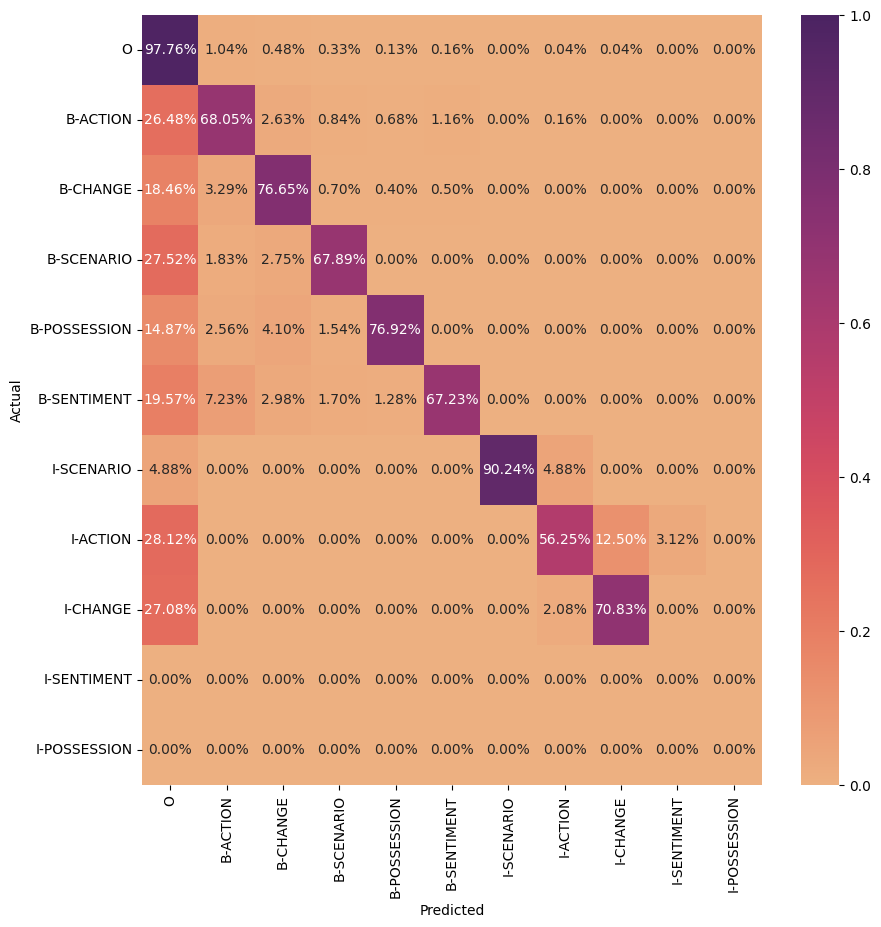

In [92]:

categories = list(dictionary.label2idx.keys())


fig, ax = plt.subplots(figsize=(10, 10))

target_tokens_flat = np.array([label for sentence_labels in target_tokens for label in sentence_labels])
output_tokens_flat = np.array([label for sentence_labels in output_tokens for label in sentence_labels])
#print(target_tokens_flat)
# Compute the confusion matrix
cm = confusion_matrix(target_tokens_flat, output_tokens_flat, labels=categories)
#print(cm)
# Format the numbers in the confusion matrix
fmt = '.2%'
total_predictions = np.sum(cm)
annot = np.empty_like(cm).astype(str)
cm = np.array(cm)

#needed to compute the percentage
column_sums = [np.sum(cm[:, i], axis=0) for i in range(cm.shape[0])]
#print(column_sums)
result = [(cm[:, i] / (column_sums[i]+0.0000001)).round(4) for i in range(cm.shape[1])]


#result = np.transpose(result)
#print(result)

# Plot the confusion matrix as a 
sns.heatmap(result, annot=result, fmt=fmt, cmap='flare',xticklabels=categories, yticklabels=categories,vmin=0, vmax=1)

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

plt.show()